# Notebook Contents

1. General

    i. Density Maps of DES data
    
    ii. Creation of movie
    
    
2. ATLAS and Phoenix

    i. Isochrone generation and matched filter technique
    
    ii. Spatial Maps
        i. RA-DEC orientation
        ii. phi1-phi2 orientation


In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/data/des81.b/data/tavangar/streams/code')
import glob

import numpy as np
import healpy as hp
import fitsio as fits
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.ndimage as nd
from utils import load_infiles

import ugali
from ugali import isochrone

import skymap, skymap.survey
from skymap.utils import cel2gal, gal2cel
from skymap.utils import setdefaults

from streamlib import skymap_factory
import streamlib
import results
import rotation_matrix
import plot_hess

import polyfit2d
from numpy.polynomial import polynomial

import importlib
import imp

import region_plot

/data/des81.b/data/tavangar/streams/code/streamlib.py:14: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/traitlets/config/application.py", line 658, i

In [2]:
sfd = hp.read_map('lambda_sfd_ebv.fits')
nside = hp.get_nside(sfd)
ra,dec = hp.pix2ang(nside,np.arange(hp.nside2npix(nside)),lonlat=True)
galpix = hp.ang2pix(nside,*cel2gal(ra,dec),lonlat=True)
sfd = sfd[galpix]

#planck = fitsio.read('COM_CompMap_ThermalDust-commander_2048_R2.00.fits')['I_ML_FULL']
planck = hp.read_map('COM_CompMap_ThermalDust-commander_2048_R2.00.fits')
nside = hp.get_nside(planck)
ra,dec = hp.pix2ang(nside,np.arange(hp.nside2npix(nside)),lonlat=True)
galpix = hp.ang2pix(nside,*cel2gal(ra,dec),lonlat=True)
planck = planck[galpix]

NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


/home/s1/tavangar/.local/lib/python2.7/site-packages/healpy/fitsfunc.py:371: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


## Plotting Functions

In [3]:
def stream_hess(data, phi1, phi2, phi1min, phi1max, stream_width, bkg_start):
    on = np.where((phi1<phi1max) & (phi1>phi1min)&(np.abs(phi2) < stream_width)) # on stream region
    onstream = data[on]
    print(len(onstream))

    off1 = np.where((phi1<phi1max) & (phi1>phi1min)& (phi2 > bkg_start) & (phi2 < bkg_start+2*stream_width)) # off stream region
    off2 = np.where((phi1<phi1max) & (phi1>phi1min)&(phi2 < (0-bkg_start)) & (phi2 > (0-(bkg_start+2*stream_width))))
    offstream1 = data[off1]
    offstream2 = data[off2]
    #plt.scatter(onstream['RA'], onstream['DEC'], s = 0.0001)
    #plt.scatter(phi1[on], phi2[on], s = 0.001)
    #plt.scatter(rrl['ra'], rrl['dec'], s = 5, c='r')

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    ax1, im1 = plot_hess.plot_hess(onstream, offstream1, ax=ax1)
    plot_iso(iso, 'r')
    fig.colorbar(im1, ax = ax1)
    plt.xlim(0,1)
    plt.ylim(24, 16)
    plt.title('Subtract Region above for phi1 = [{},{}]'.format(phi1min, phi1max))

    ax2, im2 = plot_hess.plot_hess(onstream, offstream2, ax=ax2)
    plot_iso(iso, 'r')
    plt.plot(mk[:,0], mk[:,1]+mu, c='k')
    fig.colorbar(im2, ax = ax2)
    plt.xlim(0,1)
    plt.ylim(24, 16)
    plt.title('Subtract Region below for phi1 = [{},{}]'.format(phi1min, phi1max))
    
    return ax2, im2
    
def four_stream_hess(minmax_array):
    #fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20,5))
    for i in range(len(minmax_array)):
        stream_hess(data, phi1, phi2, minmax_array[i][0], minmax_array[i][1], stream_width, bkg_start)
        
def plot_iso(iso,c):
    #plt.scatter(iso.mag_1-iso.mag_2,iso.mag_1+iso.distance_modulus,marker='o',c=c,s=3)
    plt.scatter(iso.data['g']-iso.data['r'],iso.data['g']+iso.distance_modulus,marker='o',c=c,s=3)
    #plt.gca().invert_yaxis()
    plt.xlabel('%s - %s'%(iso.band_1,iso.band_2)); plt.ylabel(iso.band_1)
    
def plot_iso2(iso,c):
    plt.scatter(iso.data['r']-iso.data['z'],iso.data['g']+iso.distance_modulus,marker='o',c=c,s=3)
    #plt.gca().invert_yaxis()
    plt.xlabel('%s - %s'%('r','z')); plt.ylabel(iso.band_1)

## Creating Spatial Maps

#### Make mask

In [3]:
# Loading hpxcubes

#hpxcube, fracdet, modulus = region_plot.load_hpxcube(
#    '/data/des81.b/data/tavangar/streams/des/DES_Y6_iso_hpxcube_z0.0004_a13.0_gmax24_gmin3p5_E2_C0p050p1.fits.gz')

#hpxcube, fracdet, modulus = region_plot.load_hpxcube(
#   '/home/s1/nshipp/projects/stream_search/data/DECaLS_iso_hpxcube_z0.0001_a13.5_gmax23_gmin3p4_E2_C-0p020p1.fits.gz')

hpxcube, fracdet, modulus = region_plot.load_hpxcube(
    '/data/des81.b/data/tavangar/streams/des/DES_Y6_iso_hpxcube_z0.0004_a13.0_gmax24.0_gmin3p5_E3_C0p01p075.fits.gz')

Reading /data/des81.b/data/tavangar/streams/des/DES_Y6_iso_hpxcube_z0.0004_a13.0_gmax24.0_gmin3p5_E3_C0p01p075.fits.gz...
Skipping fracdet...


In [5]:
print(hpxcube[:,6])

[0. 0. 0. ... 0. 0. 0.]


(array([      0,       1,       2, ..., 3145725, 3145726, 3145727]),)


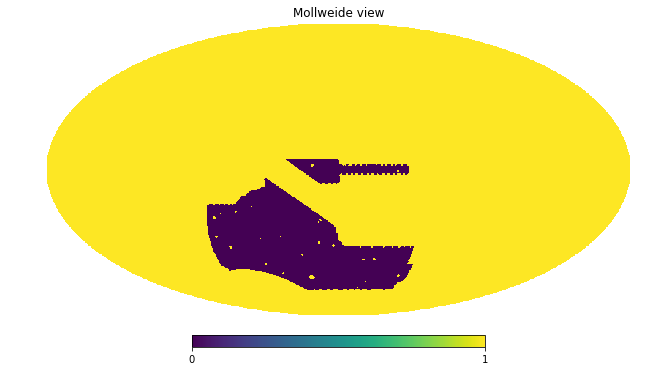

In [8]:
# make the mask
mask = streamlib.make_mask(nside=512, lmc=True, milky_way=False, sgr=True, globulars=True, dwarfs=True, 
                           galaxies=True, plane=True, bmax=25, center=True, globs_dwarfs=False, acs=False, cmax=25)

des = np.where((hpxcube[:,1] == 0) & (hpxcube[:,2] == 0) & (hpxcube[:,3] == 0) & (hpxcube[:,4] == 0) & 
              (hpxcube[:,5] == 0) & (hpxcube[:,6] == 0) & (hpxcube[:,7] == 0) & (hpxcube[:,8] == 0) &
              (hpxcube[:,9] == 0) & (hpxcube[:,10] == 0) & (hpxcube[:,11] == 0) & (hpxcube[:,12] == 0) & 
              (hpxcube[:,13] == 0) & (hpxcube[:,14] == 0) & (hpxcube[:,15] == 0) & (hpxcube[:,16] == 0) &
              (hpxcube[:,17] == 0) & (hpxcube[:,18] == 0) & (hpxcube[:,19] == 0) & (hpxcube[:,20] == 0) & 
              (hpxcube[:,0] == 0))
print(des)
mask[des] = True
#np.save('pal13/decals_mask.npy', mask)
hp.mollview(mask)

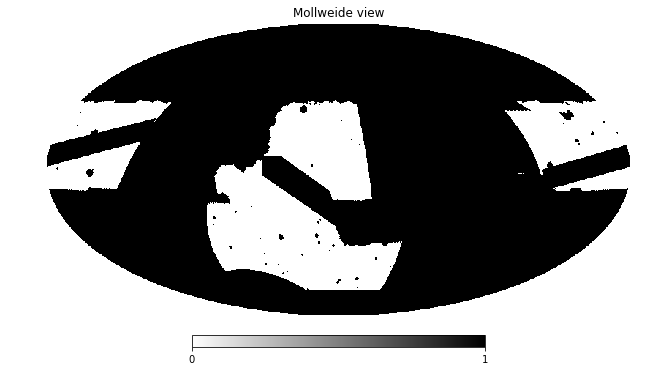

In [992]:
mask = np.load('pal13/Pal13_mask.npy')
hp.mollview(mask)

### Make Full DES Spatial Map

/data/des81.b/data/tavangar/streams/code/region_plot.py:176: RuntimeWarning: invalid value encountered in greater
  smooth[smooth>5] = np.nan
/data/des81.b/data/tavangar/streams/code/polyfit2d.py:144: RuntimeWarning: invalid value encountered in sqrt
  fit_errors = np.sqrt(np.diag(cov_mat))


Text(0.5,1,'m-M = 17.8')

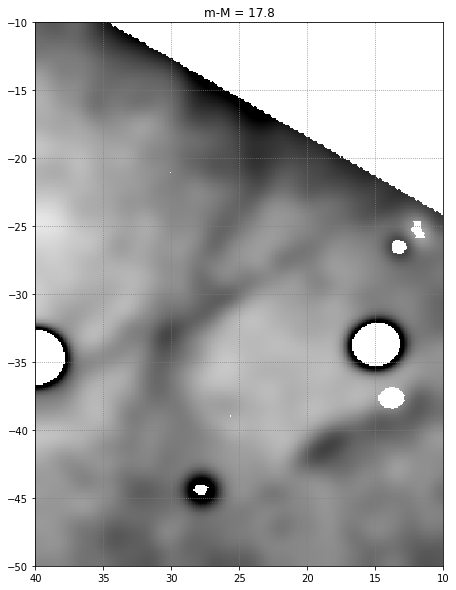

In [30]:
reload(region_plot)
%matplotlib inline
d = region_plot.prepare_hpxmap(18.0, hpxcube, fracdet, modulus)
xx,yy,vv = region_plot.run(d, dust=sfd, planck=planck, sigma = 0.8)
plt.title('m-M = 17.8')

/data/des81.b/data/tavangar/streams/code/region_plot.py:176: RuntimeWarning: invalid value encountered in greater
  smooth[smooth>5] = np.nan


Text(0.5,1,'m-M = 17.8')

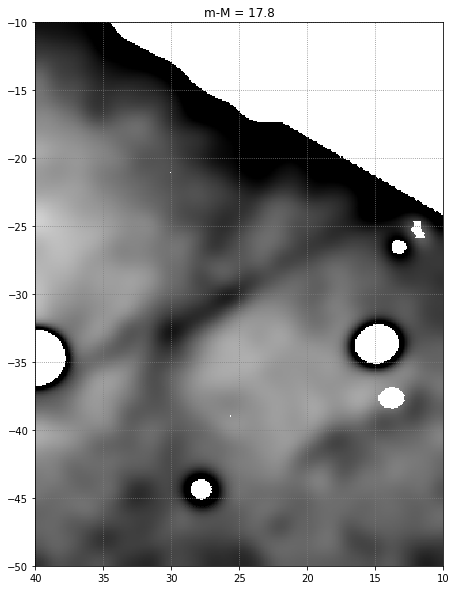

In [31]:
reload(region_plot)
%matplotlib inline
d = region_plot.prepare_hpxmap(17.6, hpxcube, fracdet, modulus)
xx,yy,vv = region_plot.run(d, dust=sfd, planck=planck, sigma = 0.8)
plt.title('m-M = 17.8')

/data/des81.b/data/tavangar/streams/code/region_plot.py:176: RuntimeWarning: invalid value encountered in greater
  smooth[smooth>5] = np.nan


Text(0.5,1,'m-M = 17.8')

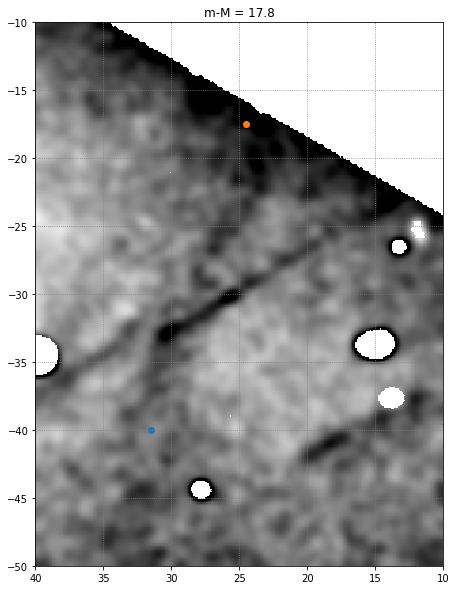

In [35]:
reload(region_plot)
%matplotlib inline
d = region_plot.prepare_hpxmap(17.8, hpxcube, fracdet, modulus)
xx,yy,vv = region_plot.run(d, dust=sfd, planck=planck, sigma = 0.4)
plt.scatter(31.5, -40)
plt.scatter(24.5, -17.5)
plt.title('m-M = 17.8')

In [24]:
full_data = np.load('full_data_skim.npy')
print(len(full_data))
full_data = full_data[full_data['EXT_SOF'] < 2]
full_data = full_data[(full_data['SOF_PSF_MAG_CORRECTED_G'] < 24.0)]# & (full_data['SOF_PSF_MAG_CORRECTED_G'] > 20.2)]
full_data = full_data[(full_data['SOF_PSF_MAG_CORRECTED_G']-full_data['SOF_PSF_MAG_CORRECTED_R'] < 1)
          &(full_data['SOF_PSF_MAG_CORRECTED_G']-full_data['SOF_PSF_MAG_CORRECTED_R'] > 0)]
print(len(full_data))

686102150
17688359


/data/des81.b/data/tavangar/streams/code/region_plot.py:541: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  p1 = np.linspace(phi1min,phi1max,nphi1pix)
/data/des81.b/data/tavangar/streams/code/region_plot.py:542: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  p2 = np.linspace(phi2min,phi2max,nphi2pix)


3.0


Text(0.5,1,'m-M = 17.8')

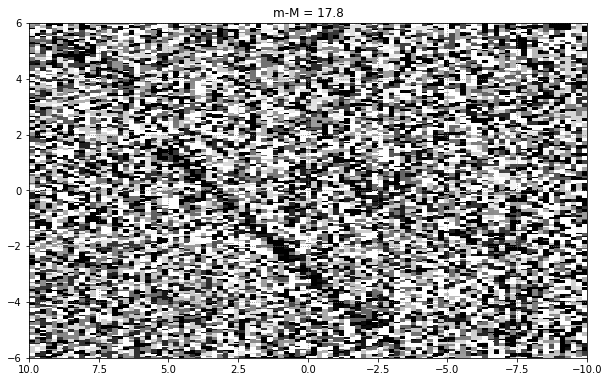

In [39]:
reload(region_plot)
%matplotlib inline
palca_ends = [31.5, -40, 24.5, -17.5]
d = region_plot.prepare_hpxmap(17.8, hpxcube, fracdet, modulus)
pp1, pp2, vv, smooth_res, smooth, vv_mask = region_plot.stream_coord_spatial(d, palca_ends, data, deg = 5, 
                                                                             stream='Palca', sigma = 0.0)
plt.title('m-M = 17.8')

[-6.   -5.95 -5.9  -5.85 -5.8  -5.75 -5.7  -5.65 -5.6  -5.55 -5.5  -5.45
 -5.4  -5.35 -5.3  -5.25 -5.2  -5.15 -5.1  -5.05 -5.   -4.95 -4.9  -4.85
 -4.8  -4.75 -4.7  -4.65 -4.6  -4.55 -4.5  -4.45 -4.4  -4.35 -4.3  -4.25
 -4.2  -4.15 -4.1  -4.05 -4.   -3.95 -3.9  -3.85 -3.8  -3.75 -3.7  -3.65
 -3.6  -3.55 -3.5  -3.45 -3.4  -3.35 -3.3  -3.25 -3.2  -3.15 -3.1  -3.05
 -3.   -2.95 -2.9  -2.85 -2.8  -2.75 -2.7  -2.65 -2.6  -2.55 -2.5  -2.45
 -2.4  -2.35 -2.3  -2.25 -2.2  -2.15 -2.1  -2.05 -2.   -1.95 -1.9  -1.85
 -1.8  -1.75 -1.7  -1.65 -1.6  -1.55 -1.5  -1.45 -1.4  -1.35 -1.3  -1.25
 -1.2  -1.15 -1.1  -1.05 -1.   -0.95 -0.9  -0.85 -0.8  -0.75 -0.7  -0.65
 -0.6  -0.55 -0.5  -0.45 -0.4  -0.35 -0.3  -0.25 -0.2  -0.15 -0.1  -0.05
  0.    0.05  0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5   0.55
  0.6   0.65  0.7   0.75  0.8   0.85  0.9   0.95  1.    1.05  1.1   1.15
  1.2   1.25  1.3   1.35  1.4   1.45  1.5   1.55  1.6   1.65  1.7   1.75
  1.8   1.85  1.9   1.95  2.    2.05  2.1   2.15  2

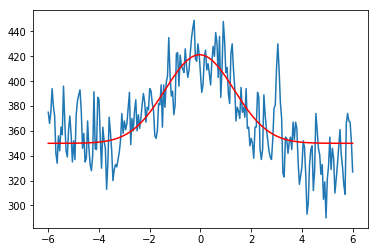

In [46]:
from scipy.stats import norm
from astropy.modeling import models, fitting

print(pp2[:,0])
print(pp2.shape)
pp2_sums = np.apply_along_axis(np.sum, 1, smooth)
print(len(pp2_sums))
plt.plot(pp2[:,0], pp2_sums)

t_init = models.Gaussian1D(amplitude= 60, mean=0)
fit_t = fitting.LevMarLSQFitter()
    
t = fit_t(t_init, pp2[:,0], pp2_sums - 350)
x_interval_for_fit = np.linspace(-6, 6, 1000)
plt.plot(x_interval_for_fit, t(x_interval_for_fit) + 350, label='fit', c='red')
print(t.mean, t.stddev)

/data/des81.b/data/tavangar/streams/code/region_plot.py:541: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  p1 = np.linspace(phi1min,phi1max,nphi1pix)
/data/des81.b/data/tavangar/streams/code/region_plot.py:542: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  p2 = np.linspace(phi2min,phi2max,nphi2pix)


4.0


Text(0.5,1,'m-M = 17.8')

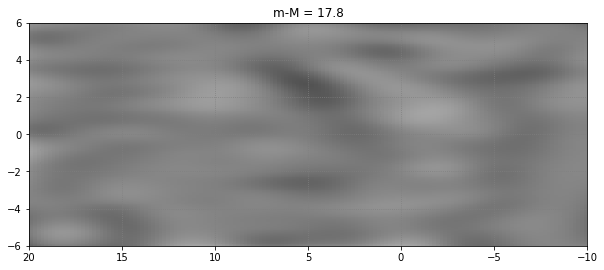

In [23]:
reload(region_plot)
%matplotlib inline
palca_ends = [30.3, -53.7, 16.2, 2.4]
d = region_plot.prepare_hpxmap(17.8, hpxcube, fracdet, modulus)
pp1, pp2, vv, smooth_res, smooth, vv_mask = region_plot.stream_coord_spatial(d, palca_ends, data, deg = 5, 
                                                                             stream='Palca', sigma = 0.8)
plt.title('m-M = 17.8')

[0. 0. 0. ... 0. 0. 0.]
1052201
[nan nan nan ... nan nan nan]


Text(0.5,1,'m-M = 17.0')

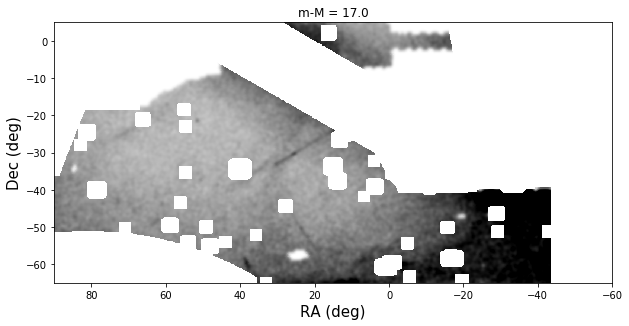

In [552]:
reload(region_plot)
%matplotlib inline
d = region_plot.prepare_hpxmap(17, hpxcube, fracdet, modulus)
xx,yy,vv = region_plot.run(d, dust=sfd, planck=planck, sigma = .4)
plt.title('m-M = 17.0')

15.0


/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  app.launch_new_instance()


15.2


/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  app.launch_new_instance()


15.4


/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  app.launch_new_instance()


15.6


/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  app.launch_new_instance()


15.8


/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  app.launch_new_instance()


16.0


/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  app.launch_new_instance()


16.2


/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  app.launch_new_instance()


16.4


/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  app.launch_new_instance()


16.6


/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  app.launch_new_instance()


16.8


/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  app.launch_new_instance()


17.0


/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  app.launch_new_instance()


17.2


/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  app.launch_new_instance()


17.4


/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  app.launch_new_instance()


17.6


/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  app.launch_new_instance()


17.8


/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  app.launch_new_instance()


18.0


/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  app.launch_new_instance()


18.2


/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  app.launch_new_instance()


18.4


/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  app.launch_new_instance()


18.6


/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  app.launch_new_instance()


18.8


/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  app.launch_new_instance()


19.0


/home/s1/tavangar/.local/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  app.launch_new_instance()


19.2


/home/s1/tavangar/.local/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  app.launch_new_instance()


19.4


/home/s1/tavangar/.local/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  app.launch_new_instance()


19.6


/home/s1/tavangar/.local/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  app.launch_new_instance()


19.8


/home/s1/tavangar/.local/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  app.launch_new_instance()


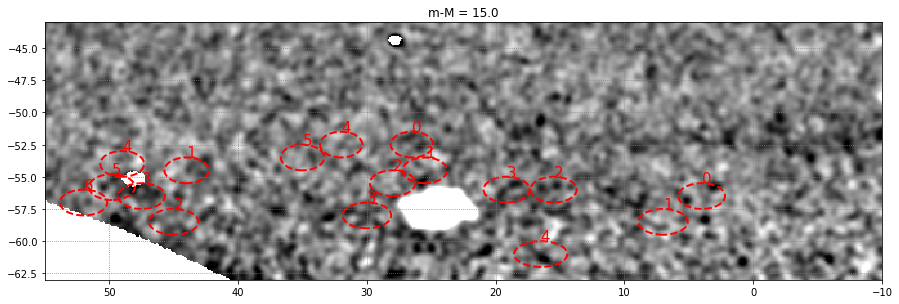

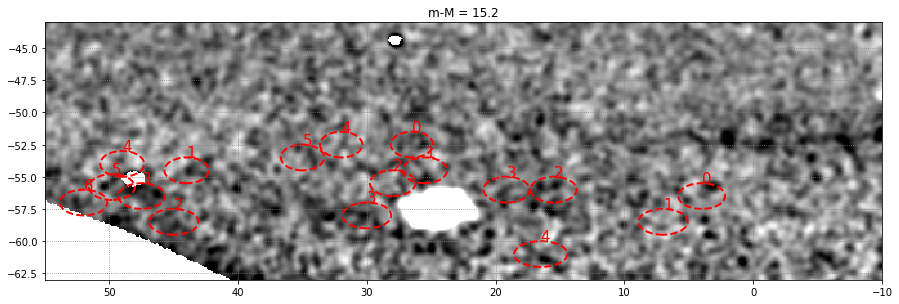

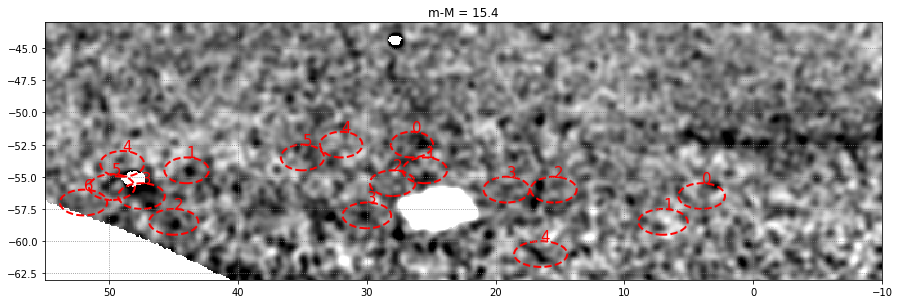

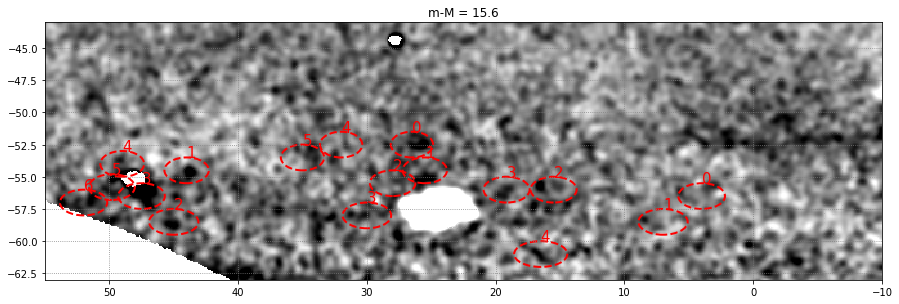

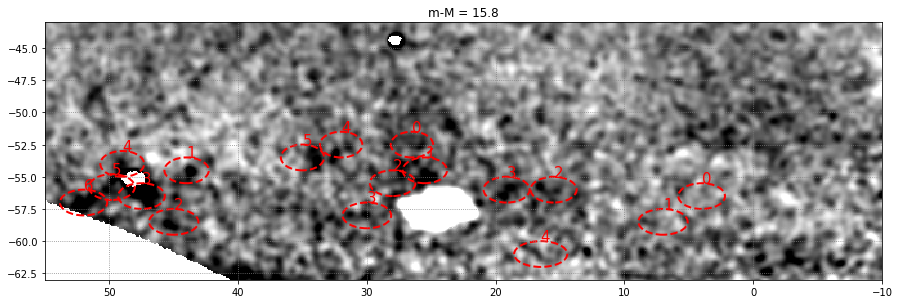

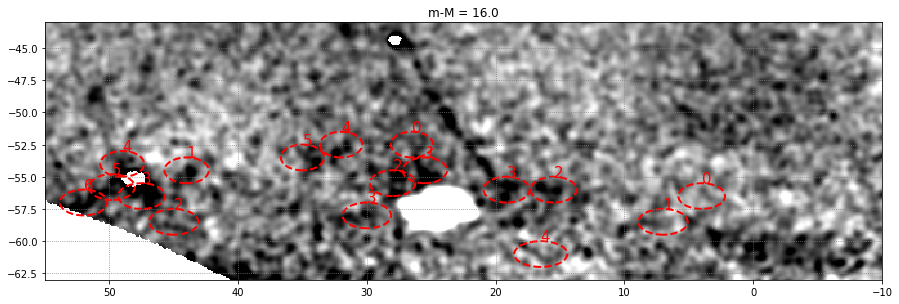

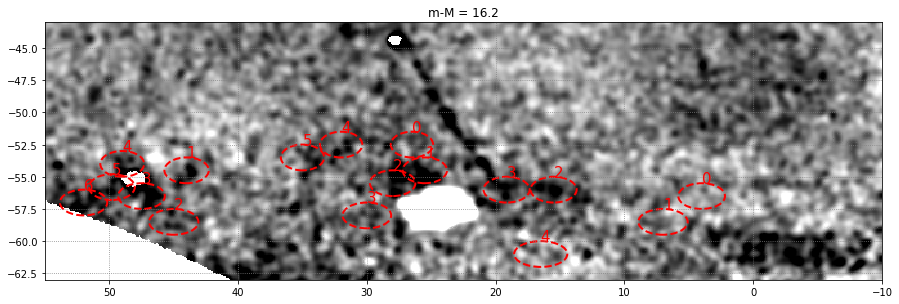

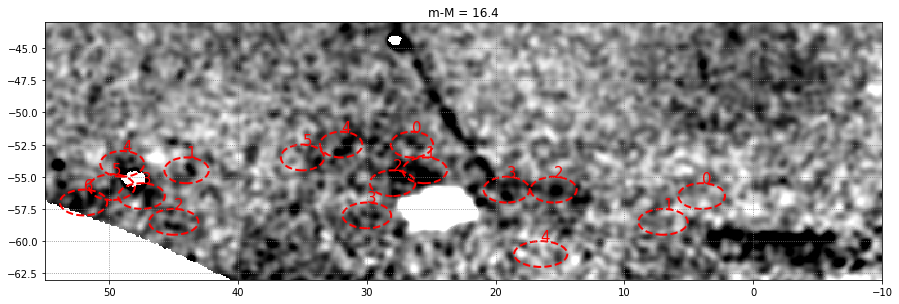

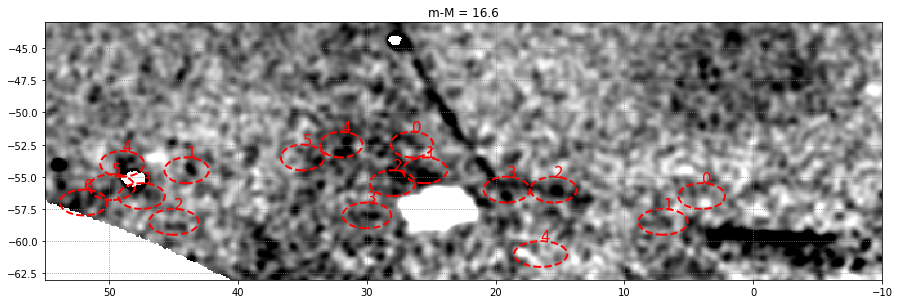

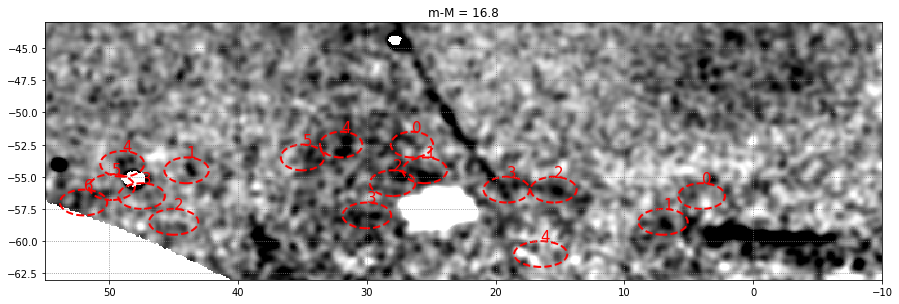

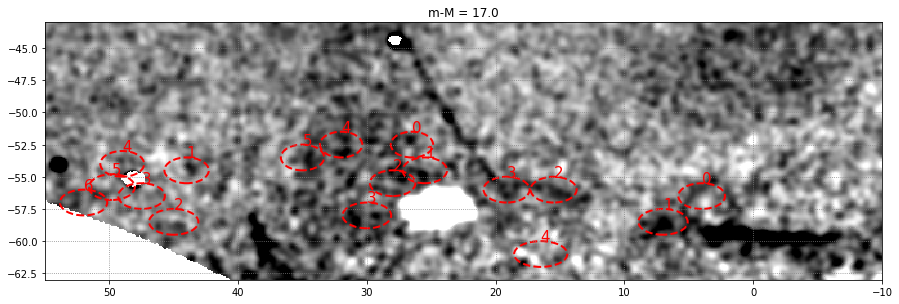

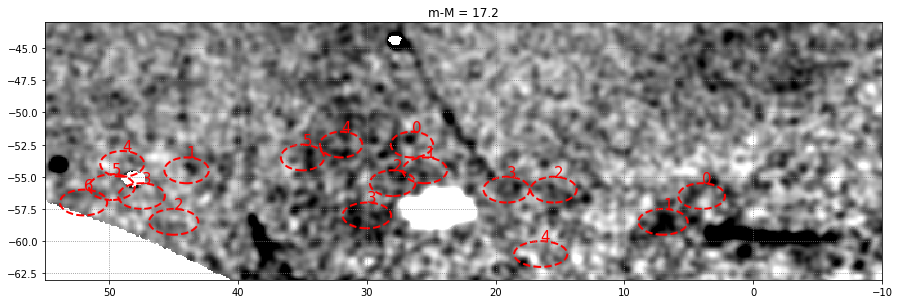

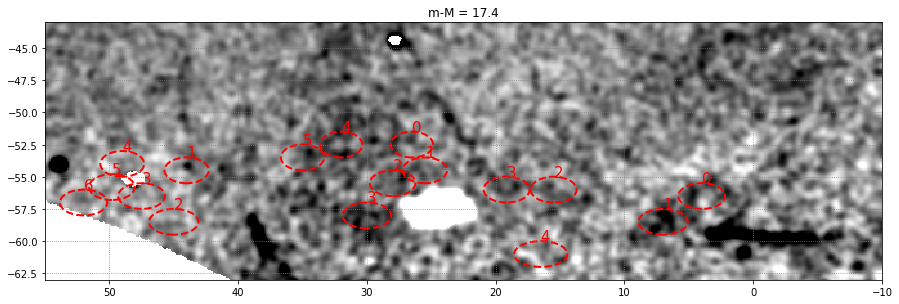

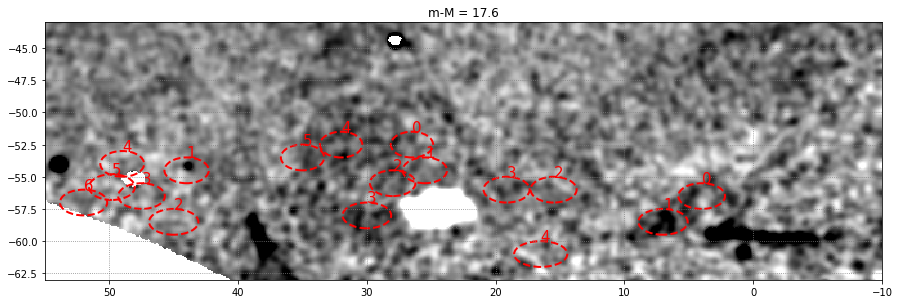

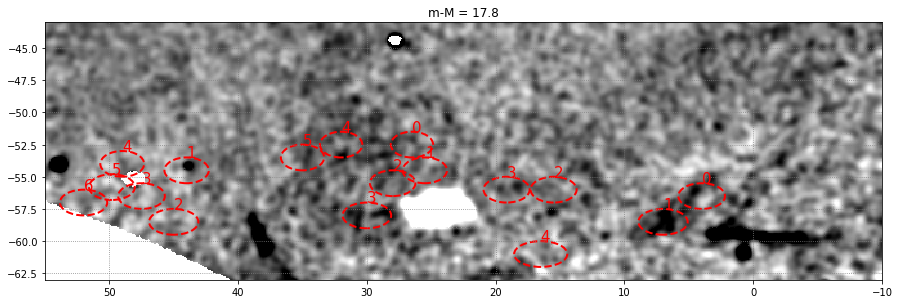

In [ ]:
# Create movie
reload(region_plot)
from PIL import Image
from matplotlib.patches import Ellipse
images = []
for i in range(150,200, 2):
    print(i/10.)
    d = region_plot.prepare_hpxmap(i/10., hpxcube, fracdet, modulus)
    xx,yy,res = region_plot.run(d, dust=sfd, planck=planck, sigma = 0.25)
    fig, ax = plt.subplots(figsize=(15,15))
    ax.pcolormesh(xx,yy,res, vmin = -1.5, vmax = 1.5, cmap = 'gray_r')
    ax.set_title('m-M = {}'.format(i/10.))
    ax.set_xlim(55,-10)
    ax.set_ylim(-63,-43)

    field = np.genfromtxt('EriPhe_pointing.csv', delimiter = ',', names=True, dtype = None)
    for j in range(len(field)):
        ells = Ellipse(xy=(field['ra'][j], field['dec'][j]), width=2/np.cos(field['dec'][j]/180.*np.pi), height=2 , 
                   angle=0 , fc=None, ec='red', lw=2,fill=False, ls='--') 
        ax.add_artist(ells)
        ax.text(field['ra'][j], field['dec'][j]+1, field['pt'][j], color='r', size = 15)
    ax.set_aspect('equal')
    plt.grid('on',ls = ':',color='gray')
    plt.savefig('/data/des81.b/data/tavangar/streams/des/eriphe_mov/{}_eriphe_AAT_prep.jpg'.format(str(i)), dpi=100)

In [66]:
images[0].save('des/eriphe.gif', save_all=True, append_images=images, optimize=True, duration=150, loop=0)

AttributeError: 'numpy.float64' object has no attribute 'save'

## Data Extraction and Cuts

In [6]:
#load the des data to create the isochrones
filenames = glob.glob('/data/des81.b/data/tavangar/skim_y6_gold_1_1/*.fits')
full_data = load_infiles(filenames,columns=[
    'RA','DEC','SOF_PSF_MAG_CORRECTED_G','SOF_PSF_MAG_CORRECTED_R','SOF_PSF_MAG_CORRECTED_I','EXT_SOF'],multiproc=8)

NameError: name 'data' is not defined

In [7]:
full_data = full_data[full_data['EXT_SOF'] < 2]
full_data = full_data[(full_data['SOF_PSF_MAG_CORRECTED_G'] < 24.0)]# & (full_data['SOF_PSF_MAG_CORRECTED_G'] > 20.2)]
full_data = full_data[(full_data['SOF_PSF_MAG_CORRECTED_G']-full_data['SOF_PSF_MAG_CORRECTED_R'] < 1)
          &(full_data['SOF_PSF_MAG_CORRECTED_G']-full_data['SOF_PSF_MAG_CORRECTED_R'] > 0)]
print(len(full_data))

17688359


## EriPhe Overdensity

In [5]:
reload(region_plot)

%matplotlib inline
d = region_plot.prepare_hpxmap(16.8, hpxcube, fracdet, modulus)
xx,yy,res = region_plot.run(d, dust=sfd, planck=planck, sigma = 0.25)

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  if __name__ == '__main__':


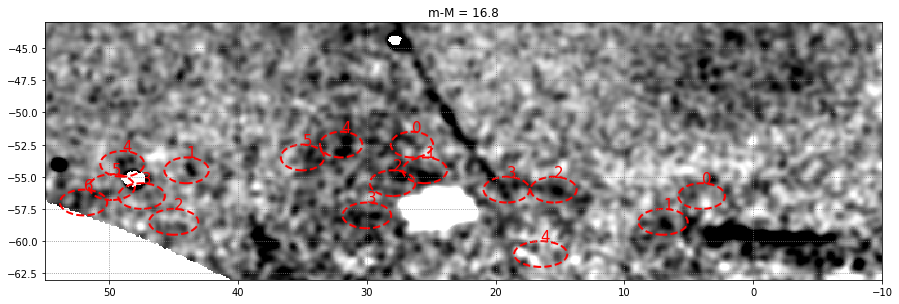

In [7]:
fig, ax = plt.subplots(figsize=(15,15))
ax.pcolormesh(xx,yy,res, vmin = -1.5, vmax = 1.5, cmap = 'gray_r')
ax.set_title('m-M = 16.8')
ax.set_xlim(55,-10)
ax.set_ylim(-63,-43)


from matplotlib.patches import Ellipse
field = np.genfromtxt('EriPhe_pointing.csv', delimiter = ',', names=True, dtype = None)
for j in range(len(field)):
    ells = Ellipse(xy=(field['ra'][j], field['dec'][j]), width=2/np.cos(field['dec'][j]/180.*np.pi), height=2 , 
                   angle=0 , fc=None, ec='red', lw=2,fill=False, ls='--') 
    ax.add_artist(ells)
    ax.text(field['ra'][j], field['dec'][j]+1, field['pt'][j], color='r', size = 15)
ax.set_aspect('equal')
plt.grid('on',ls = ':',color='gray')

## ATLAS stream

In [8]:
#create the isochrones to find the best distance modulus
data = np.copy(full_data)

(-65, -10)

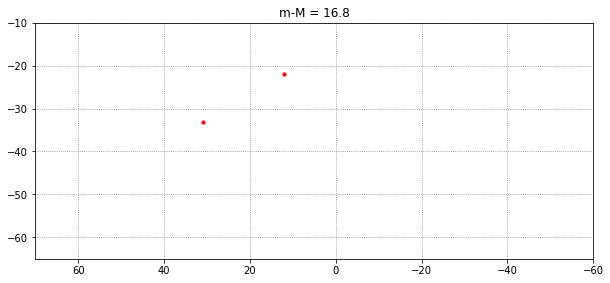

In [9]:
reload(region_plot)
%matplotlib inline
d = region_plot.prepare_hpxmap(16.8, hpxcube, fracdet, modulus)
xx,yy,vv = region_plot.run(d, dust=sfd, planck=planck, sigma = 0.2)
plt.scatter(31, -33.2, s = 10, c='r')
plt.scatter(12, -22, s = 10, c='r')
plt.title('m-M = 16.8')
plt.xlim(70,-60)
plt.ylim(-65,-10)

In [10]:
# rotate everything
atlas_ends = [31, -33.2, 12, -22]
# rotate everything
phi1, phi2, R = streamlib.rotation(atlas_ends, data['RA'], data['DEC'])
print(phi1, phi2)

(array([-35.14213886, -35.14343964, -34.86924235, ...,  40.0290172 ,
        40.02215009,  40.0245788 ]), array([ 14.92130772,  14.90740459,  15.14319933, ..., -25.00893581,
       -25.01631397, -25.02515348]))


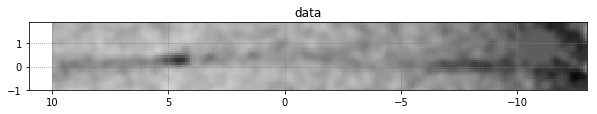

In [21]:
reload(region_plot)
d = region_plot.prepare_hpxmap(16.8, hpxcube, fracdet, modulus)
pp1, pp2, vv, res, smooth, vv_mask = region_plot.stream_coord_spatial(d, atlas_ends, full_data, 
                                                                      deg =5, sigma=0.15, stream = 'ATLAS')
np.save('model_arrays/pp1_atlas.npy', pp1)
np.save('model_arrays/pp2_atlas.npy', pp2)
np.save('model_arrays/vv_atlas.npy', vv)
np.save('model_arrays/smooth_atlas.npy', smooth)
plt.xlim(11, -13)
np.save('model_arrays/vv_mask_atlas.npy', vv_mask)

In [917]:
g_on = onstream['SOF_PSF_MAG_CORRECTED_G']
r_on = onstream['SOF_PSF_MAG_CORRECTED_R']
i_on = onstream['SOF_PSF_MAG_CORRECTED_I']

g_off2 = offstream1['SOF_PSF_MAG_CORRECTED_G']
r_off2 = offstream1['SOF_PSF_MAG_CORRECTED_R']
i_off2 = offstream1['SOF_PSF_MAG_CORRECTED_I']

g_off2 = offstream2['SOF_PSF_MAG_CORRECTED_G']
r_off2 = offstream2['SOF_PSF_MAG_CORRECTED_R']
i_off2 = offstream2['SOF_PSF_MAG_CORRECTED_I']

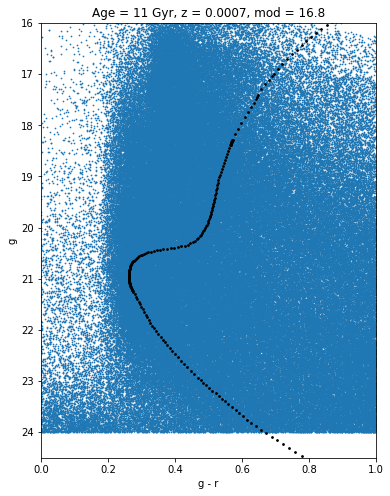

In [918]:
plt.figure(figsize=(6,8))
plt.scatter(g_on-r_on, g_on, s = 0.5)
plt.xlim(0,1)
plt.ylim(24.5, 16)
plot_iso(iso, 'k')
plt.title('Age = 11 Gyr, z = 0.0007, mod = 16.8')

plt.show()

53750
('dx, dy = ', 0.04, 0.16666666666666666)
('dx, dy = ', 0.04, 0.16666666666666666)
15286
('dx, dy = ', 0.04, 0.16666666666666666)
('dx, dy = ', 0.04, 0.16666666666666666)
13336
('dx, dy = ', 0.04, 0.16666666666666666)
('dx, dy = ', 0.04, 0.16666666666666666)
12418
('dx, dy = ', 0.04, 0.16666666666666666)
('dx, dy = ', 0.04, 0.16666666666666666)
12710
('dx, dy = ', 0.04, 0.16666666666666666)
('dx, dy = ', 0.04, 0.16666666666666666)


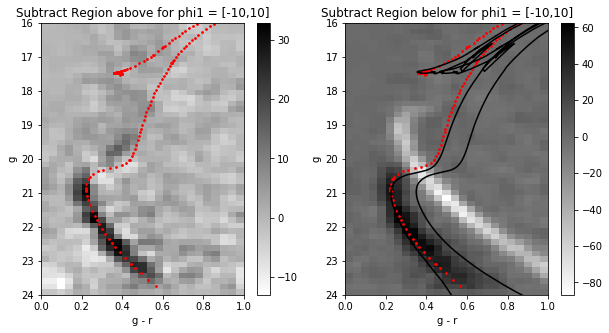

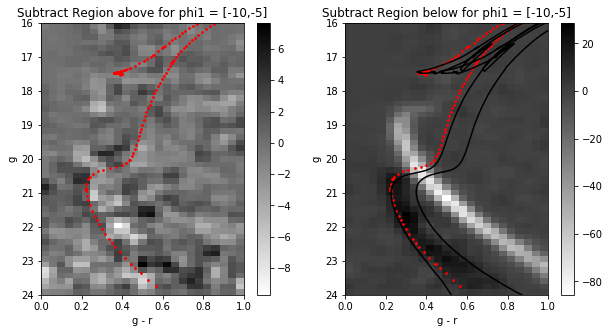

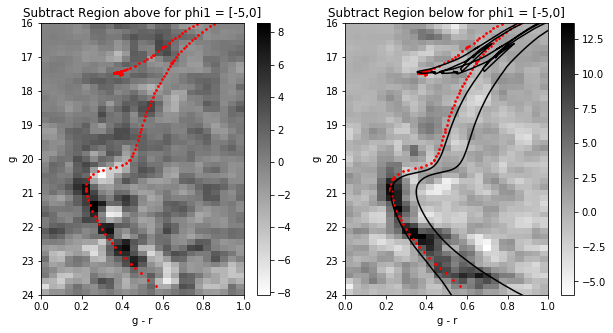

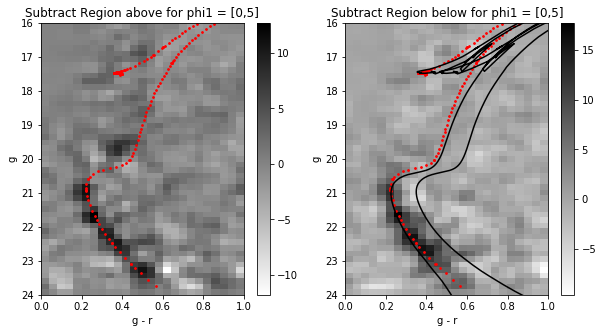

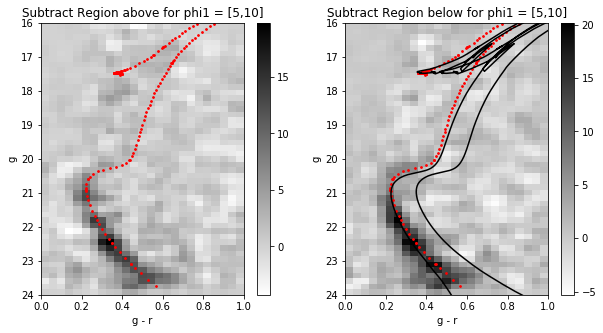

In [919]:
iso = isochrone.factory(name='Padova',
                        age=11,  # Gyr
                        metallicity=0.0007, # Z
                        distance_modulus=16.8 #16.8 for left half of stream, 16.5 for right half
                       )

stream_width = 0.75
bkg_start = 2.5
stream_hess(data, phi1, phi2, -10, 10, stream_width, bkg_start)
atlas_quarters = [[-10,-5], [-5,0], [0,5], [5,10]]
four_stream_hess(atlas_quarters)

('dx, dy = ', 0.04, 0.16666666666666666)
('dx, dy = ', 0.04, 0.16666666666666666)


(24, 16)

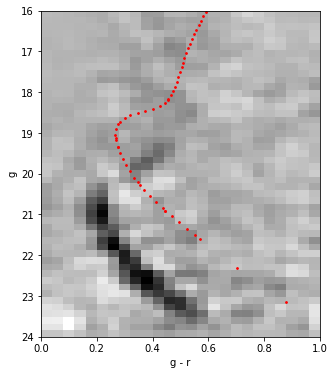

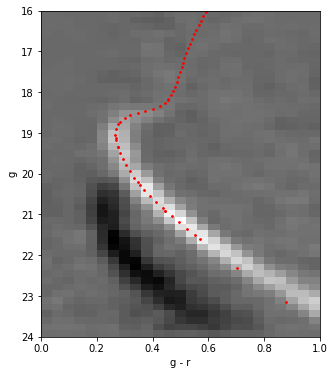

In [321]:
iso = isochrone.factory(name='Padova',
                        age=13.5,  # Gyr
                        metallicity=0.001, # Z
                        distance_modulus=14.7
                       )

plot_hess.plot_hess(onstream, offstream1)
plot_iso(iso, 'r')
plt.xlim(0,1)
plt.ylim(24, 16)

plot_hess.plot_hess(onstream, offstream2)
plot_iso(iso, 'r')
plt.xlim(0,1)
plt.ylim(24, 16)

## Phoenix Stream

In [ ]:
#create the isochrones to find the best distance modulus

(-65, -35)

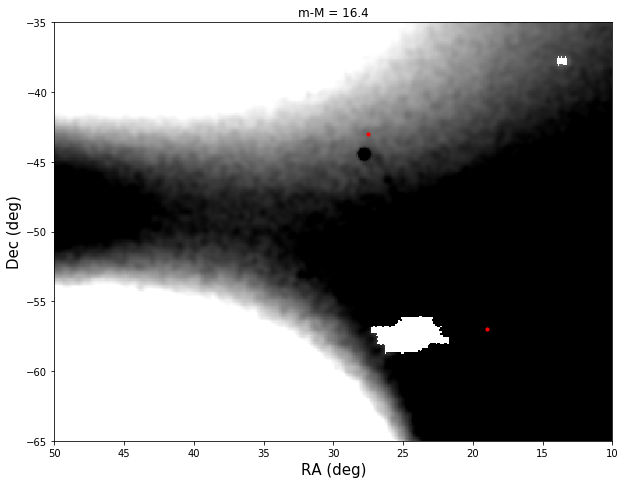

In [1100]:
reload(region_plot)
%matplotlib inline
d = region_plot.prepare_hpxmap(16.4, hpxcube, fracdet, modulus)
xx,yy,vv = region_plot.run(d, dust=sfd, planck=planck, sigma = .2)
plt.title('m-M = 16.4')
plt.scatter(19, -57, s = 10, c='r')
plt.scatter(27.5, -43, s = 10, c='r')
plt.xlim(50,10)
plt.ylim(-65,-35)

In [156]:
data = np.copy(full_data)

In [557]:
# rotate everything
phoenix_ends = [19, -57, 27.5, -43]
phi1, phi2 = streamlib.rotation(phoenix_ends, data['RA'], data['DEC'])
print(phi1, phi2)

(array([-48.50918235, -48.4947404 , -48.58511538, ...,  15.45676358,
        15.46096777,  15.47046208]), array([-37.84256635, -37.85061756, -37.50332254, ...,  20.0506648 ,
        20.04185768,  20.04000709]))


In [471]:
g_on = onstream['SOF_PSF_MAG_CORRECTED_G']
r_on = onstream['SOF_PSF_MAG_CORRECTED_R']
i_on = onstream['SOF_PSF_MAG_CORRECTED_I']

g_off1 = offstream1['SOF_PSF_MAG_CORRECTED_G']
r_off1 = offstream1['SOF_PSF_MAG_CORRECTED_R']
i_off1 = offstream1['SOF_PSF_MAG_CORRECTED_I']

g_off2 = offstream2['SOF_PSF_MAG_CORRECTED_G']
r_off2 = offstream2['SOF_PSF_MAG_CORRECTED_R']
i_off2 = offstream2['SOF_PSF_MAG_CORRECTED_I']

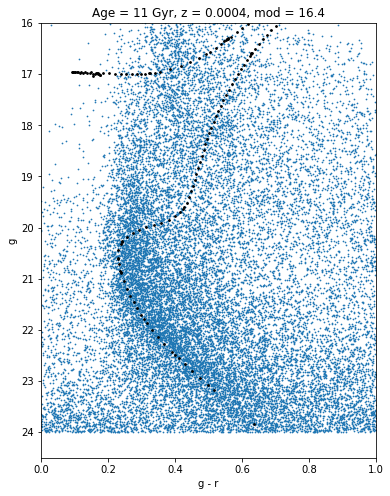

In [473]:
plt.figure(figsize=(6,8))
plt.scatter(g_on-r_on, g_on, s = 0.5)
plt.xlim(0,1)
plt.ylim(24.5, 16)
plot_iso(iso, 'k')
plt.title('Age = 11 Gyr, z = 0.0004, mod = 16.4')

plt.show()

22328
('dx, dy = ', 0.04, 0.16666666666666666)
('dx, dy = ', 0.04, 0.16666666666666666)
4773
('dx, dy = ', 0.04, 0.16666666666666666)
('dx, dy = ', 0.04, 0.16666666666666666)
5221
('dx, dy = ', 0.04, 0.16666666666666666)
('dx, dy = ', 0.04, 0.16666666666666666)
5926
('dx, dy = ', 0.04, 0.16666666666666666)
('dx, dy = ', 0.04, 0.16666666666666666)
6408
('dx, dy = ', 0.04, 0.16666666666666666)
('dx, dy = ', 0.04, 0.16666666666666666)


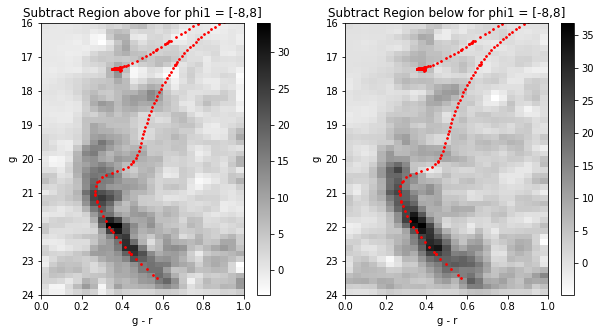

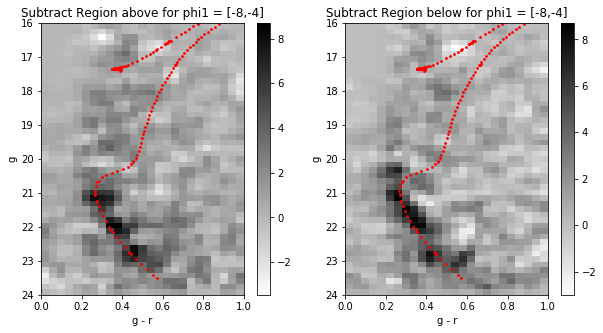

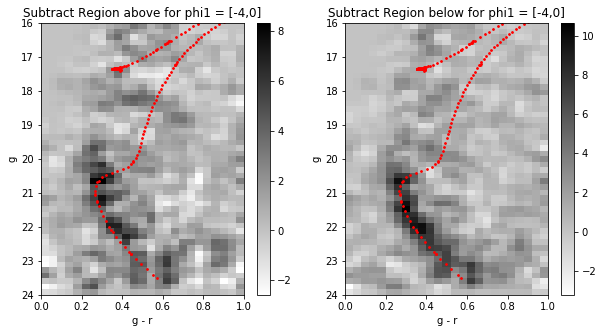

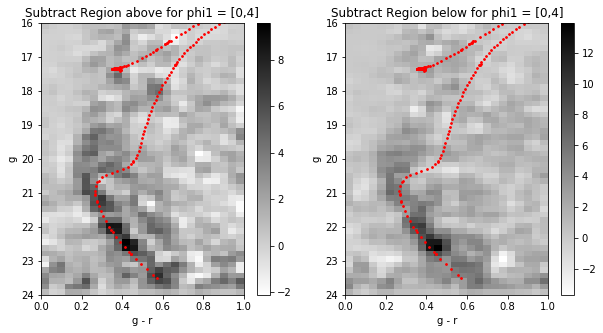

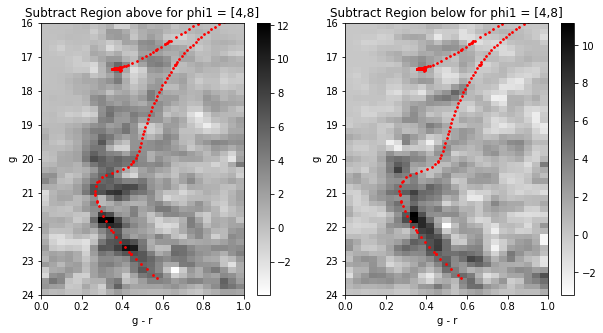

In [558]:
iso = isochrone.factory(name='Padova',
                        age=13.5,  # Gyr
                        metallicity=0.001, # Z
                        distance_modulus=16.6
                       )

stream_width = 0.3
bkg_start = 2
stream_hess(data, phi1, phi2, -8, 8, stream_width, bkg_start)

four_stream_hess([[-8,-4], [-4,0], [0,4], [4,8]])

### NOTE:
To convert hpxcube coordinates, convert each pixel to angle and then apply the coordinate transformation as above.
Or: use the rotation function I defined in streamlib and for the ra and dec inputs, use pix2ang for all pixels in hpxcube. Then you are going to have phi1, phi2, vv as in region_plot.py. Need to find a way to meshgrid phi1, phi2. For each pixel that maps into that grid, make vv[phi1, phi2] = pixel value

In [93]:
hpxcube, fracdet, modulus = region_plot.load_hpxcube(
    '/data/des81.b/data/tavangar/streams/des/DES_Y6_iso_hpxcube_z0.0001_a11.0_gmax24_gmin3p5_E2_C0p050p1.fits.gz')

Reading /data/des81.b/data/tavangar/streams/des/DES_Y6_iso_hpxcube_z0.0001_a11.0_gmax24_gmin3p5_E2_C0p050p1.fits.gz...
Skipping fracdet...


[-15.  -14.9 -14.8 ...  14.8  14.9  15. ]
30401
(array([ 4.46699495,  4.5492383 ,  4.63154916, ..., 38.61914627,
       38.72467532, 38.83030308]), array([-22.77706982, -22.84169641, -22.90629226, ..., -30.85673342,
       -30.89821523, -30.93959753]))
30401
30401
30401
[[0. 0. 0. ... 3. 7. 3.]
 [0. 0. 0. ... 3. 5. 7.]
 [0. 0. 0. ... 4. 5. 1.]
 ...
 [0. 0. 0. ... 2. 2. 3.]
 [0. 0. 0. ... 4. 2. 1.]
 [0. 0. 0. ... 3. 3. 3.]]


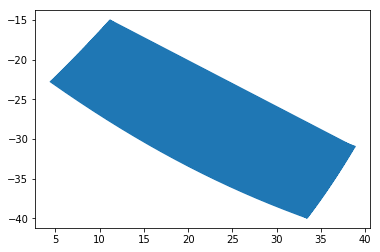

In [721]:
reload(streamlib)
d = region_plot.prepare_hpxmap(16.8, hpxcube, fracdet, modulus)
nside = 512
phi1min, phi1max = -15, 15
phi2min, phi2max = -5,5
pixscale=0.1

nphi1pix = int((phi1max-phi1min)/pixscale) + 1
nphi2pix = int((phi2max-phi2min)/pixscale) + 1

p1 = np.linspace(phi1min,phi1max,nphi1pix)
p2 = np.linspace(phi2min,phi2max,nphi2pix)
pp1,pp2 = np.meshgrid(p1,p2)
print(pp1.flat[:])
print(len(pp1.flat))

#find vv[phi1, phi2]
#vv[p1,p2] = 
atlas_phi_ends = [-12,0,12,0]
#want to rotate backwards from phi1, phi2 to ra, dec
ra, dec = streamlib.inv_rotation(atlas_phi_ends, pp1.flat[:], pp2.flat[:],R)
plt.plot(ra, dec)
print(ra, dec)
print(len(ra))
pix = hp.ang2pix(nside,ra,dec,lonlat=True)
print(len(pix))
val = d[pix]
print(len(val))
vv = val.reshape(pp1.shape)

#lon, lat = hp.pix2ang(512,range(len(d)), lonlat=True)
#phi1, phi2 = streamlib.rotation(atlas_ends, lon, lat)
#print(phi1, phi2)
#keep = np.where((np.abs(phi1)<15) & (np.abs(phi2)<5))
#print(keep)

#ra1, dec1 = hp.pix2ang(512,keep, lonlat=True)
#phi1, phi2 = streamlib.rotation(atlas_ends, ra1, dec1)
#pp1, pp2 = np.meshgrid(p1, p2)

#da = d[keep]
#print(da)
#print(len(da))
#vv = da.reshape(pp1)
        
print(vv)

In [764]:
def draw_image(xx,yy,data,**kwargs):
    #kwargs.update(vmin=0,vmax=20)
    ax = plt.gca()
    ax.pcolormesh(xx,yy,data,vmin=-2, vmax=2)
    ax.set_aspect('equal')
    ax.invert_xaxis()
    ax.set_ylabel('Dec (deg)', fontsize=15)
    ax.set_xlabel('RA (deg)', fontsize=15)

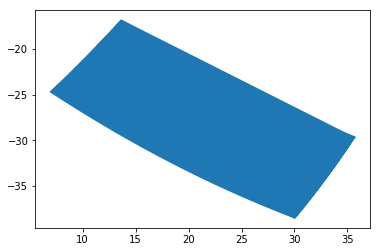

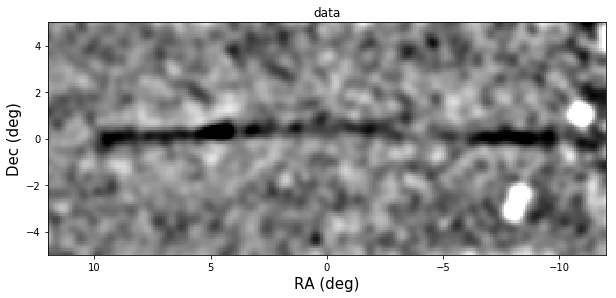

In [777]:
d = region_plot.prepare_hpxmap(16.8, hpxcube, fracdet, modulus)

def stream_coord_spatial(hpxmap, ends, sigma=0.2):
    nside = 512
    phi1min, phi1max = -12, 12
    phi2min, phi2max = -5,5
    pixscale=0.1

    nphi1pix = int((phi1max-phi1min)/pixscale) + 1
    nphi2pix = int((phi2max-phi2min)/pixscale) + 1

    p1 = np.linspace(phi1min,phi1max,nphi1pix)
    p2 = np.linspace(phi2min,phi2max,nphi2pix)
    pp1,pp2 = np.meshgrid(p1,p2)

    phi1, phi2, R = streamlib.rotation(ends, data['RA'], data['DEC'])
    
    #want to rotate backwards from phi1, phi2 to ra, dec
    ra, dec = streamlib.inv_rotation(pp1.flat[:], pp2.flat[:],R)
    plt.plot(ra, dec)
    pix = hp.ang2pix(nside,ra,dec,lonlat=True)
    val = d[pix]

    vv = val.reshape(pp1.shape)
    
    smooth = nd.gaussian_filter(vv, sigma=sigma/pixscale)

    deg = 5
    coeff = polyfit2d(pp1.flat, pp2.flat, smooth.flat, [deg, deg])
    bkg = polynomial.polyval2d(pp1, pp2, coeff)
    
    plt.figure(figsize=(10,10))
    plt.title('data')
    plt.set_cmap('gray_r')
    #draw_image(xx,yy,bkg,**kwargs)

    draw_image(pp1,pp2,smooth-bkg)
    
stream_coord_spatial(d, atlas_ends)

# Problems to ask about

Masking and then smoothing enlarges the masked area. But smoothing then masking sometimes doesn't mask the whole area since that area has been enlarged by smoothing

Background generation. Is there a way to make it by excluding nan pixels?
Try excluding the coordinates we want. Except I expect this to give me length of array problems.
Maybe try making flat, removing, doing background, then adding back so that arrays are same length if the above doesn't work

# Questions

What is the assumption on the stream like feature at the bottom right on Phoenix that is about perpendicular to the stream?